# CONVOLUCIÓN

En este módulo trabajaremos la convolución para señales de 1D (series de tiempo). Dividiremos el módulo en 3 secciones:

1. Convolución entre señales en 1D para explicar el proceso matemático de la operación. 
2. Convolución en series de tiempo, aplicación de filtro de media para datos estáticos
3. Convolución en series de tiempo, aplicación para filtrar datos reales de un sensor

La convolución en 1D se realiza entre dos señales 1D, una de ellas es la señal de entrada (I), y a la segunda le llamamos kernel de convolución (k). En la operación de convolución el kernel sufre una operación de folding o reflexión y luego se desplaza a lo largo de la señal de entrada, sumando los productos de los elementos que se solapan de k en I.

## 1. Convolución 1D, ejemplo básico

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Creamos una señal de entrada I, y un kernel de convolución k. Luego graficamos las señales y verificamos su longitud.

Longitud de la señal de entrada: 7
Longitud del kernel de convolucion: 3


<StemContainer object of 3 artists>

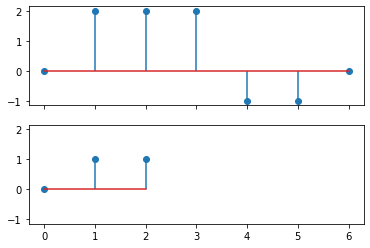

In [2]:
I = np.array([0,2,2,2,-1,-1,0])
k = np.array([0,1,1])

print('Longitud de la señal de entrada: {}'.format(len(I)))
print('Longitud del kernel de convolucion: {}'.format(len(k)))

fig, axs = plt.subplots(2,sharex=True, sharey=True)

axs[0].stem(I)
axs[1].stem(k)

Realizamos la operacion de convolución entre I y k

In [3]:
S = np.convolve(I,k)
print('La longitud de S debe ser (len(I)+ len(k)-1): {}'.format(len(S)))

La longitud de S debe ser (len(I)+ len(k)-1): 9


<StemContainer object of 3 artists>

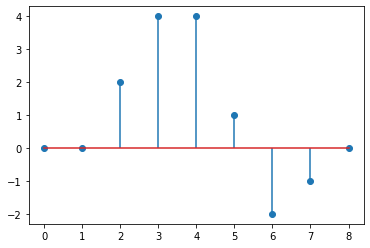

In [4]:
plt.stem(S)

# 3. Convolución 1D filtro de media datos estaticos

Cargamos datos que representan series de tiempo. En este caso datos de un sensor de velocidad de un motor.

In [5]:
import pandas as pd
Datos = pd.read_csv('3.data/Motor.csv')
Datos.head()

,Tiempo,Amplitud
0,3.655582,0.00
1,3.716871,0.00
2,3.773982,5.06
3,3.835531,35.58
4,3.895979,62.75


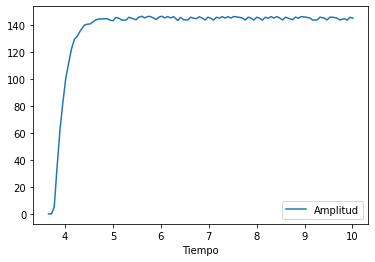

In [6]:
Datos.plot(x='Tiempo',y='Amplitud')
plt.show()

- Separamos del dataframe los datos del sensor y los datos de tiempo.
- Definimos un kernel de convolución que tiene la caracterìstica de que la suma de todos sus datos es 1.
- Luego hacemos la operación de convolución entre los datos del sensor I y el kernel k.

In [7]:
Datos_numpy=Datos.to_numpy()
I=Datos_numpy[:,1]
t=Datos_numpy[:,0]

k=np.array([0.25,0.25,0.25,0.25])
S=np.convolve(I,k,mode='same')
print(len(S),len(I),len(k))


99 99 4


Graficamos la señal original y la señal después de la operación de convolución

<IPython.core.display.Javascript object>


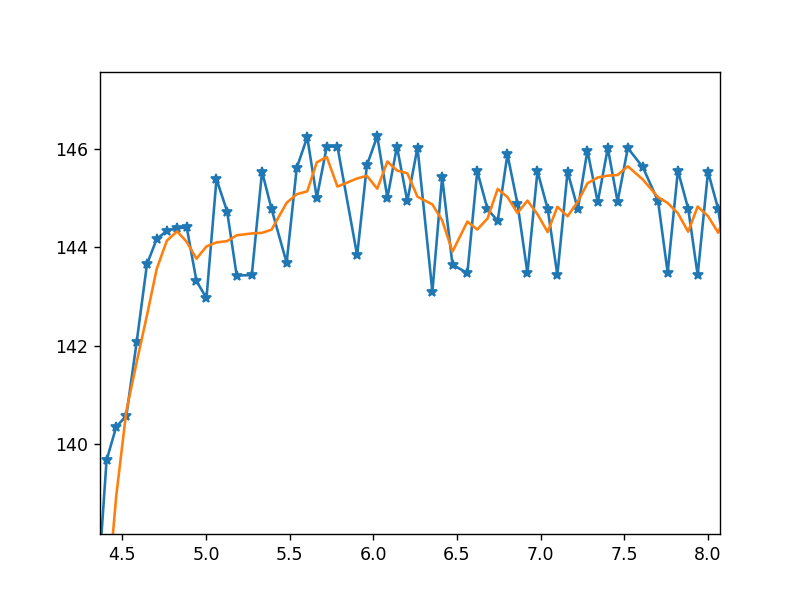

In [12]:
%matplotlib notebook
plt.ion() 

fig, ax1 = plt.subplots(1)
ax1.plot(t,I,'-*')
ax1.plot(t[1:-1] ,S[1:-1] ,'-')
plt.show()

# 3. Convolución 1D filtro de media, datos reales de un sensor

Usaremos la libreria pyserial para la adquisición serial. En el repositorio encontrarán un código de arduino para adquirir y enviar al computador los datos de un sensor.

In [9]:
!pip install pyserial

## Visualización en tiempo real

In [10]:
import serial
import numpy as np
from matplotlib import pyplot as plt
from time import time
import re

%matplotlib notebook

Iniciamos la comunicación serial. Deben asegurarse que la etiqueta del puerto y el BaudRate correspondan. En este caso la adquisición se realiza por el COM3 y a 230400 Baudios.

- En el repositorio encontrarán el código de Arduino que lee el puerto analógico A1 y envía la información por serial cada 30ms
- El sensor usado en esta prueba es un sensor de presión, pero pueden usar cualquier sensor con salida analógica de voltaje

<IPython.core.display.Javascript object>


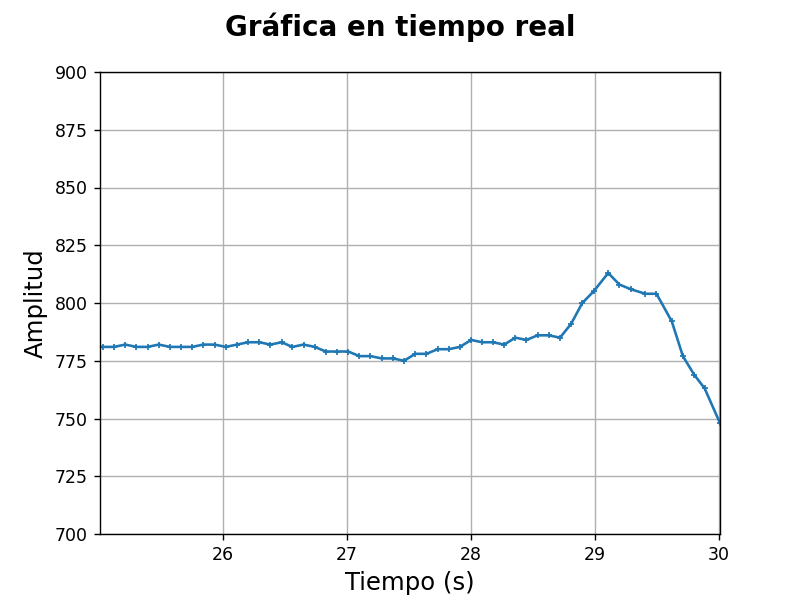

D:\Programas\miniconda3\envs\MiEntorno\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


In [14]:
# Iniciamos comunicación serial
com_ser = serial.Serial('/COM3', 230400)
com_ser.flushInput()

# Configuración en la visualización
RangoY = [700,900]    # Define el rango de la gráfica en el eje y
VentanaTiempo = 5   # Define la ventana de tiempo que si visualiza en tiempo real
TiempoFinal = 30    # Define el tiempo total de adquisición 

# Configuración de la figura
plt.ion() 
figura1 = plt.figure()
figura1.suptitle('Gráfica en tiempo real', fontsize='16', fontweight='bold')
plt.xlabel('Tiempo (s)', fontsize='14')
plt.ylabel('Amplitud', fontsize='14')
plt.axes().grid(True)

# Lista para guardar datos Tiempo y Amplitud
timepoints = []
ydata = []

# Configuración de la curva
line1, = plt.plot(ydata, marker='+',markersize=4,linestyle='-')
plt.ylim(RangoY)
plt.xlim([0,VentanaTiempo])

run = True
start_time = time()


while run:
    com_ser.reset_input_buffer()
    data = str(com_ser.readline()) # Lectura del puerto

    # El envío se realiza con un marcador $, sólo si la trama tiene ese marcador se separará los datos de la trama
    if(len(data.split('$'))>=2):
        data_sp=data.split('$')[1].split('\\r\\n')[0]

    try:
        # Agregamos los datos de amplitud y tiempo a cada lista
        ydata.append(float(data_sp))
        timepoints.append(time()-start_time)
        current_time = timepoints[-1]
        
        # Se actutaliza los datos en la grafica 
        line1.set_xdata(timepoints)
        line1.set_ydata(ydata)
        
        # Se actualiza la ventan de observación de la gráfica
        if current_time > VentanaTiempo:
            plt.xlim([current_time-VentanaTiempo,current_time])
            
        # La ejecución termina cuando el tiempo de ejecución llega al límite
        if timepoints[-1] > TiempoFinal: run=False
    
    except: pass
    
    # Actualiza la gráfica
    figura1.canvas.draw()

# Cierra el puerto serial
com_ser.close()    

- Convertimos las listas ydatay timepoints en arrays numpy.
- Creamos un kernel para filtro de media
- Realizamos la convolución entre la señal y el kernel, usamos mode='same' para tomar solamente los datos que se solapan

In [15]:
I=np.array(ydata) 
t=np.array(timepoints) 

k=np.array([0.25,0.25,0.25,0.25])
S=np.convolve(I,k,mode='same')
print(len(S),len(I),len(k))

297 297 4


Finalmente graficamos la señal filtrada y sin filtrar

<IPython.core.display.Javascript object>


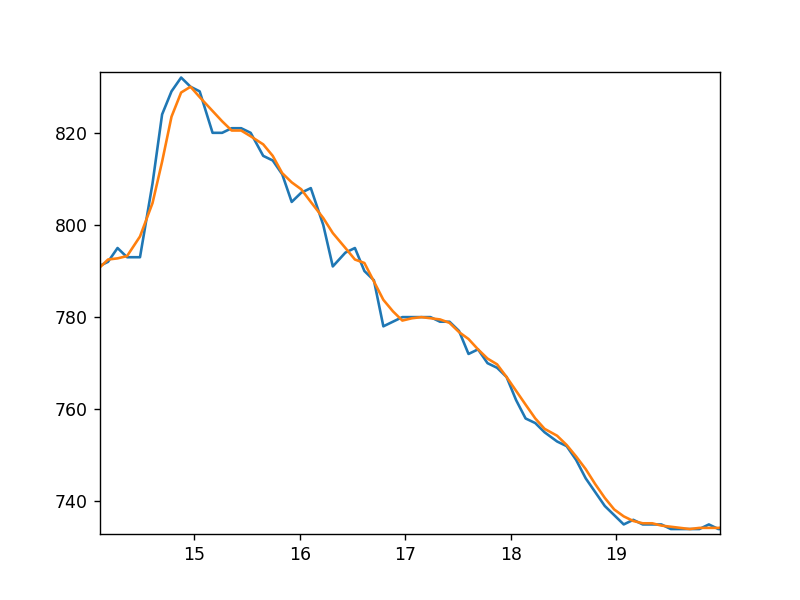

In [16]:
fig, ax1 = plt.subplots(1)
ax1.plot(t,I,'-')
ax1.plot(t[2:-1] ,S[2:-1] ,'-')
plt.show()

Guardamos los datos sin filtrar, en nuestro disco

In [ ]:
datos= {'Tiempo':timepoints,'Amplitud':ydata}
df = pd.DataFrame(datos)
df.to_csv('DatosRegistrados.csv', index=False)

# Taller

* Reproducir el experimento anterior con cualquier sensor con salida analógica de voltaje
* Realizar la convolución con un kernel de longitud 10 y comparar los resultados